In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')
#import denn.utils
from collections import OrderedDict

COLORS = ["crimson", "blue", "aquamarine"]

def load_traces(dirname, skipstep=1):
    soln = np.load(os.path.join(dirname, "soln_pred.npy"))
    grid = np.load(os.path.join(dirname, "grid.npy"))
    pred = np.load(os.path.join(dirname, "pred_pred.npy"))

    print(f"Grid {grid.shape} Soln {soln.shape} Pred {pred.shape}")

    # skipping for gif size
    soln = soln[:,::skipstep]
    grid = grid[:,::skipstep]
    pred = pred[:,::skipstep]

    return dict(soln=soln, grid=grid, pred=pred)

def load_mse(dirname, skipstep=1):
    grid = np.load(os.path.join(dirname, "grid.npy"))
    train = np.load(os.path.join(dirname, "train_mse.npy"))
    val = np.load(os.path.join(dirname, "val_mse.npy"))
    
    # Find the minimum validation MSE and corresponding step
    min_val = val.min()
    min_step = np.argmin(val)
    min_val_step = [min_val, min_step]
    
    # skipping for gif size
    train = train[::skipstep]
    val = val[::skipstep]

    return dict(grid=grid, train=train, val=val, min_val_step=min_val_step)

def load_loss(dirname, skipstep=1):
    grid = np.load(os.path.join(dirname, "grid.npy"))
    G_loss = np.load(os.path.join(dirname, "G_loss.npy"))
    D_loss = np.load(os.path.join(dirname, "D_loss.npy"))
    real_loss = np.load(os.path.join(dirname, "D real_loss.npy"))
    fake_loss = np.load(os.path.join(dirname, "D fake_loss.npy"))
    LHS_loss = np.load(os.path.join(dirname, "LHS_loss.npy"))
    
    # Find the minimum LHS loss and corresponding step
    min_LHS = LHS_loss.min()
    min_step = np.argmin(LHS_loss)
    min_LHS_step = [min_LHS, min_step]
    
    # skipping for gif size
    G_loss = G_loss[::skipstep]
    D_loss = D_loss[::skipstep]
    real_loss = real_loss[::skipstep]
    fake_loss = fake_loss[::skipstep]
    LHS_loss = LHS_loss[::skipstep]

    return dict(grid=grid, G_loss=G_loss, D_loss=D_loss, real_loss=real_loss, fake_loss=fake_loss, 
                LHS_loss=LHS_loss, min_LHS=min_LHS, min_LHS_step=min_LHS_step)

def load_multiline_traces(dirname, numlines, skipstep=1):
    soln = np.load(os.path.join(dirname, "soln_pred.npy"))
    grid = np.load(os.path.join(dirname, "grid.npy"))
    pred = np.load(os.path.join(dirname, "pred_pred.npy"))

    print(f"Grid {grid.shape} Soln {soln.shape} Pred {pred.shape}")
    
    res = dict(grid=grid)
    
    for i in range(numlines):
        _pred = pred[:, i::numlines]
        _soln = soln[:, i::numlines]
        res[f"pred{i}"] = _pred[:, ::skipstep] # skip for gif size, if desired
        res[f"soln{i}"] = _soln[:, ::skipstep]

    return res

def load_surface_traces(dirname, skipstep=1):
    soln = np.load(os.path.join(dirname, "soln_pred.npy"))
    grid = np.load(os.path.join(dirname, "grid.npy"))
    pred = np.load(os.path.join(dirname, "pred_pred.npy"))

    print(f"Grid {grid.shape} Soln {soln.shape} Pred {pred.shape}")
    
    pred = pred[:, ::skipstep]
    
    return dict(grid=grid, pred=pred)

def make_line_ax(v, ax):
    line1, = ax.plot([],[], lw=3, linestyle="solid", color='crimson', alpha=0.7, label="pred")
    line2, = ax.plot([],[], lw=3, linestyle="dashed", color='blue', alpha=0.7, label="true")
    y_minima = [v['soln'].min(), v['pred'].min()]
    y_maxima = [v['soln'].max(), v['pred'].max()]
    ax.set_xlim(v['grid'].min(), v['grid'].max())
    ax.set_ylim(min(y_minima), max(y_maxima))
    return OrderedDict(dict(pred=line1, soln=line2))

def make_mse_ax(v, ax):
    line1, = ax.plot([],[], lw=3, linestyle="solid", color='crimson', alpha=0.7, label="train")
    line2, = ax.plot([],[], lw=3, linestyle="dashed", color='blue', alpha=0.7, label="val")
    ax.set_xlim(v['grid'].min(), v['grid'].max()*200)
    ax.set_ylim(v['train'].min(), v['train'].max())
    return OrderedDict(dict(train=line1, val=line2))

def make_loss_ax(v, ax):
    line1, = ax.plot([],[], lw=3, linestyle="solid", color='crimson', alpha=0.7, label="G")
    line2, = ax.plot([],[], lw=3, linestyle="dashed", color='blue', alpha=0.7, label="D")
    line3, = ax.plot([],[], lw=3, linestyle="dashdot", color='skyblue', alpha=0.7, label="D real")
    line4, = ax.plot([],[], lw=3, linestyle="dotted", color='limegreen', alpha=0.7, label="D fake")
    line5, = ax.plot([],[], lw=3, linestyle="solid", color='aquamarine', alpha=0.7, label="LHS")
    y_minima = [v['G_loss'].min(), v['D_loss'].min(), v['real_loss'].min(), v['fake_loss'].min(), v['LHS_loss'].min()]
    y_maxima = [v['G_loss'].max(), v['D_loss'].max(), v['real_loss'].max(), v['fake_loss'].max(), v['LHS_loss'].max()]
    ax.set_xlim(v['grid'].min(), v['grid'].max()*200)
    ax.set_ylim(min(y_minima), max(y_maxima))
    return OrderedDict(dict(G_loss=line1, D_loss=line2, real_loss=line3, fake_loss=line4, LHS_loss=line5))

def fill_line_data(lines, i, t, v):
    x = v['grid'].flatten()
    j = min(i, v['pred'].shape[1] - 1)
    pred = v['pred'][:, j]
    soln = v['soln'][:, j]
    lines[t]['pred'].set_data(x, pred)
    lines[t]['soln'].set_data(x, soln)
    
def fill_mse_data(lines, i, t, v):
    j = min(i, v['train'].shape[0] - 1)
    x = v['grid'].flatten()[:j]
    x = [x_i*200 for x_i in x]
    train = v['train'][:j]
    val = v['val'][:j]
    lines[t]['train'].set_data(x, train)
    lines[t]['val'].set_data(x, val)
    
def fill_loss_data(lines, i, t, v):
    j = min(i, v['G_loss'].shape[0] - 1)
    x = v['grid'].flatten()[:j]
    x = [x_i*200 for x_i in x]
    G_loss = v['G_loss'][:j]
    D_loss = v['D_loss'][:j]
    real_loss = v['real_loss'][:j]
    fake_loss = v['fake_loss'][:j]
    LHS_loss = v['LHS_loss'][:j]
    lines[t]['G_loss'].set_data(x, G_loss)
    lines[t]['D_loss'].set_data(x, D_loss)
    lines[t]['real_loss'].set_data(x, real_loss)
    lines[t]['fake_loss'].set_data(x, fake_loss)
    lines[t]['LHS_loss'].set_data(x, LHS_loss)
    
def make_multiline_ax(v, ax):
    numlines = (len(v.keys()) - 1)//2
    res = {}
    
    for i in range(numlines):
        pred, = ax.plot([],[], lw=3, linestyle="solid", color=COLORS[i], alpha=0.7, label="pred")
        soln, = ax.plot([],[], lw=3, linestyle="dashed", color=COLORS[i], alpha=0.7, label="true")
        res[f"pred{i}"] = pred
        res[f"soln{i}"] = soln

    ax.set_xlim(v['grid'].min(), v['grid'].max())
    
    ymin = min([v[f'soln{i}'].min() for i in range(numlines)])
    ymax = max([v[f'soln{i}'].max() for i in range(numlines)])
    
    ax.set_ylim(ymin, ymax)
    
    return OrderedDict(res)

def fill_multiline_data(lines, i, t, v):
    x = v['grid'].flatten()
    for k in lines[t].keys():
        j = min(i, v[k].shape[1] - 1)
        lines[t][k].set_data(x, v[k][:, j])
    
def make_surface_ax(v, ax):
    x, y, = v['grid'][:,0], v['grid'][:, 1]
    xdim, ydim = int(np.sqrt(len(x))), int(np.sqrt(len(y)))
    surf = ax.contourf(np.zeros((xdim, ydim)), cmap='Reds')
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    return OrderedDict(dict(pred=surf))

def fill_surface_data(ax, i, t, v):
    x, y = v['grid'][:,0], v['grid'][:,1]
    j = min(i, v['pred'].shape[1] - 1)
    z = v['pred'][:, j]
    
    xdim, ydim = int(np.sqrt(len(x))), int(np.sqrt(len(y)))
    xx, yy = x.reshape((xdim, ydim)), y.reshape((xdim, ydim))
    z = z.reshape((xdim, ydim))
    
    ax.contourf(xx, yy, z, cmap="Reds")

def make_animation(name, traces):
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    ax = ax.ravel()

    lines = {}
    for i, (t, v) in enumerate(traces.items()):
        if t == "POS":
            lines[t] = make_surface_ax(v, ax[i])
        elif t in ["NAS", "SIR"]:
            lines[t] = make_multiline_ax(v, ax[i])
        else:
            lines[t] = make_line_ax(v, ax[i])
        ax[i].set_title(t)
        
    fig.tight_layout()

    def animate(i):
        for tidx, (t, v) in enumerate(traces.items()):
            if t == "POS":
                fill_surface_data(ax[tidx], i, t, v)
            elif t in ["NAS", "SIR"]:
                fill_multiline_data(lines, i, t, v)
            else:
                fill_line_data(lines, i, t, v)

        artists = [ll for l in lines.values() for ll in l.values()]
        return artists

    anim = FuncAnimation(fig, animate, frames=100, interval=1, blit=False)


    anim.save(f'{name}.gif')

In [3]:
'''
exp = "/Users/dylanrandle/Downloads/EXP_run_061220_anim/animation/"
sho = "/Users/dylanrandle/Downloads/SHO_run_061220_anim/animation/"
nlo = "/Users/dylanrandle/Downloads/NLO_run_061220_anim/animation/"
coo = "/Users/dylanrandle/Downloads/COO_run_061220_anim/animation/"
sir = "/Users/dylanrandle/Downloads/SIR_run_061220_anim/animation/"
pos = "/Users/dylanrandle/Downloads/POS_run_061220_anim/animation/"

exptr = load_traces(exp, skipstep=20)
shotr = load_traces(sho, skipstep=100)
nlotr = load_traces(nlo, skipstep=200)
cootr = load_multiline_traces(coo, 2, skipstep=500)
sirtr = load_multiline_traces(sir, 3, skipstep=300)
postr = load_surface_traces(pos, skipstep=40)

traces = OrderedDict({
    "EXP": exptr,
    "SHO": shotr,
    "NLO": nlotr,
    "NAS": cootr,
    "SIR": sirtr,
    "POS": postr
})

make_animation('deqgan', traces)
'''

'\nexp = "/Users/dylanrandle/Downloads/EXP_run_061220_anim/animation/"\nsho = "/Users/dylanrandle/Downloads/SHO_run_061220_anim/animation/"\nnlo = "/Users/dylanrandle/Downloads/NLO_run_061220_anim/animation/"\ncoo = "/Users/dylanrandle/Downloads/COO_run_061220_anim/animation/"\nsir = "/Users/dylanrandle/Downloads/SIR_run_061220_anim/animation/"\npos = "/Users/dylanrandle/Downloads/POS_run_061220_anim/animation/"\n\nexptr = load_traces(exp, skipstep=20)\nshotr = load_traces(sho, skipstep=100)\nnlotr = load_traces(nlo, skipstep=200)\ncootr = load_multiline_traces(coo, 2, skipstep=500)\nsirtr = load_multiline_traces(sir, 3, skipstep=300)\npostr = load_surface_traces(pos, skipstep=40)\n\ntraces = OrderedDict({\n    "EXP": exptr,\n    "SHO": shotr,\n    "NLO": nlotr,\n    "NAS": cootr,\n    "SIR": sirtr,\n    "POS": postr\n})\n\nmake_animation(\'deqgan\', traces)\n'

In [4]:
def loss_pred_animation(name, traces):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5.5))
    ax = ax.ravel()
    
    lines = {}
    for i, (t, v) in enumerate(traces.items()):
        if t == "MSE":
            lines[t] = make_mse_ax(v, ax[i])
            min_val = v['min_val_step'][0]
            min_val_step = v['min_val_step'][1]
            ax[i].set_xlabel('Step')
            ax[i].set_yscale('log')
            ax[i].set_title(t + f'\nstep = {min_val_step}\nmin val = {min_val}')
        if t == "EXP":
            lines[t] = make_line_ax(v, ax[i])
            ax[i].set_xlabel('$t$')
            ax[i].set_title(t)
        if t == "Loss":
            lines[t] = make_loss_ax(v, ax[i])
            min_LHS = v['min_LHS_step'][0]
            min_LHS_step = v['min_LHS_step'][1]
            ax[i].set_xlabel('Step')
            ax[i].set_title(t + f'\nstep = {min_LHS_step}\nmin LHS = {min_LHS}')
        ax[i].legend()
        
    fig.tight_layout()

    def animate(i):
        for tidx, (t, v) in enumerate(traces.items()):
            if t == "MSE":
                fill_mse_data(lines, i, t, v)
            if t == "EXP":
                fill_line_data(lines, i, t, v)
            if t == "Loss":
                fill_loss_data(lines, i, t, v)

        artists = [ll for l in lines.values() for ll in l.values()]
        return artists

    anim = FuncAnimation(fig, animate, frames=100, interval=1, blit=False)

    anim.save(f'{name}.gif', writer='pillow')

Grid (100, 1) Soln (100, 2000) Pred (100, 2000)


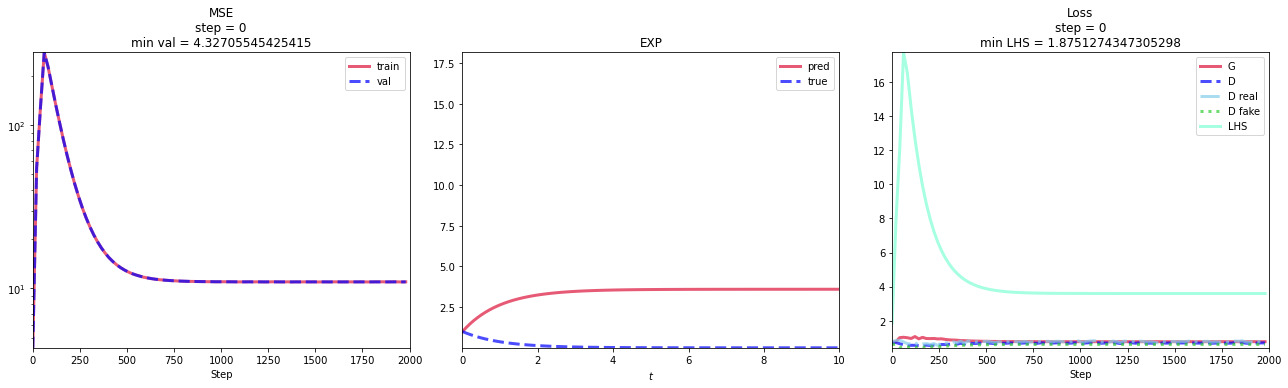

In [38]:
exp_run = "/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/EXP_run"
exp = "/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/EXP_run/animation"

msetr = load_mse(exp_run, skipstep=20)
exptr = load_traces(exp, skipstep=20)
losstr = load_loss(exp_run, skipstep=20)

traces = OrderedDict({
    "MSE": msetr,
    "EXP": exptr,
    "Loss": losstr
})

loss_pred_animation('exp', traces)